# Restless multi-armed bandit

The restless or drifting bandits are a variant of dynamic multi-armed bandits in which reward probability changes continiously. A common description of the restless Bernoulli bandits are the following difference equations for the reward probabilities $p_{t,l}$ of each arm $l$

\begin{equation}
    \textrm{logit}(p_{t,l}) = \textrm{logit}(p_{t-1, l}) + \sqrt{\sigma} \cdot n_t 
\end{equation}
where $n_t \sim \mathcal{N}(0, 1)$ and $p_0 \sim U(0, 1)$. Here we will consider a same noise level on all arms set to $\sigma=0.01$.

Note than changes occur independently on different arms of the bandit. We will start with the generative process for the restless bandits.

In [1]:
import gc

import numpyro as npyro
import numpyro.distributions as dist

import jax.numpy as np
from jax.scipy.special import logit, digamma, gammaln
from jax import random, lax, nn, ops

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

K = 3 
sigma = .1
seed = 4904842

def process(t, choices, probs, rng_key):
    
    lp = logit(probs)
    
    rng_key, _rng_key = random.split(rng_key)
    change = random.normal(_rng_key, shape=probs.shape)
    
    new_probs = nn.sigmoid(lp + sigma * change)
   
    rng_key, _rng_key = random.split(rng_key)
    outcomes = random.bernoulli(_rng_key, probs)
    
    N = choices.shape[0]
    
    return outcomes[None].repeat(N, 0), new_probs

def simulator(process, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, probs, choices = carry
        rng_key, _rng_key = random.split(rng_key)
        rng_key, _rng_key = random.split(rng_key)
        
        outcomes, probs = process(t, choices, probs, _rng_key)
        
        return (rng_key, probs, choices), {'rewards': outcomes, 'probs': probs}
    
    rng_key = random.PRNGKey(seed)
    probs = random.uniform(rng_key, shape=(K,))
    choices = np.zeros(N, dtype=np.int32)
    
    _, sequence = lax.scan(sim_fn, (rng_key, probs, choices), np.arange(T))
    
    sequence['probs'] = np.concatenate([probs[None], sequence['probs']], 0)[:-1]
    
    return sequence

In [2]:
sequence = simulator(process)

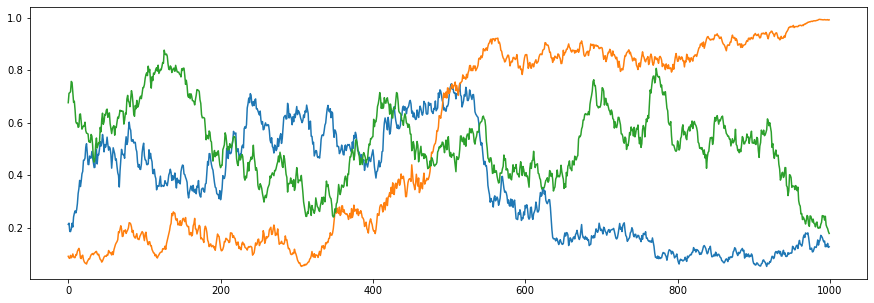

In [3]:
plt.subplots(figsize=(15, 5))
plt.plot(sequence['probs']);

Equivalent to the inference algorithm defined for piecewise-stationary bandits here we will assume that reward probability is defined only in $D$ descrete values  

$$ p \in P = \left\{\frac{1}{2D}, \ldots, 1-1/D\right\}$$

where $D$ denotes number of discrete values and $|P| = D$. And similarly for state transition probability

$$ \rho \in R = \left\{ \frac{1}{2M}, \ldots, 1-\frac{1}{M} \right\}, \qquad |R| = M$$

Hence we will infer time evolution of reward probabilities using hierarchical hidden markov model, with learnable change probabilities.

In contrast to the piecewise-stationary bandits we will assume that the transitions between arms are independent. Hence, we will drop the dependence on hidden state signaling change and define state transition probability as 

$$ p(\vec{k}_{t,l}|\vec{k}_{t-1, l}, r_{t-1}) = \prod_{l=1}^K p(k_{t,l}|k_{t-1,l}, r_{t-1})$$

\begin{equation}
    p(k_{t,l}=k^{\prime}|k_{t-1,l}=k, r_{t-1}) = \left\{ \begin{array}{cc}
        1 - \rho_{r_{t-1}} & \textrm{for } k^\prime = k  \\
        \rho_{r_{t-1}} & \textrm{for } k^\prime \neq k
    \end{array}
    \right.
\end{equation}

As previously, we will define the $r_t$ transition probabability as a 1D random walk

\begin{equation}
    p(r_t=q|r_{t-1}=r) = \left\{ \begin{array}{cc}
        \delta_{q, r} & \textrm{with Pr. } 1 - \kappa  \\
        \delta_{q, r + 1} & \textrm{with Pr. } \frac{\kappa}{2} \\
        \delta_{q, r - 1} & \textrm{with Pr. } \frac{\kappa}{2}
    \end{array}
    \right.
\end{equation}

The belief update becomes

$$ p(\vec{k}_t, r_t|\vec{o}_{1:t}, a_{1:t}) \propto p(\vec{o}_t|\vec{k}_t, a_t) p(\vec{k}_t, r_t| \vec{o}_{1:t-1}, a_{1:t-1})$$

In [4]:
from itertools import product
from jax.scipy.special import logsumexp

M = 50
kappa = 1e-4
pr_r = (1 - kappa) * np.eye(M) + kappa * (np.diag(np.ones(M-1), 1) + np.diag(np.ones(M-1), -1))/2
pr_r = ops.index_update(pr_r, ops.index[[0, -1], [1, -2]], kappa)

D = 10
rho = np.arange(1/(2*M), 1, 1/M).reshape(-1, 1, 1)

tm = (1 - rho) * np.eye(D) + rho * (np.ones((D,D)) - np.eye(D))/(D-1)
args = [tm] * K
pk_kr = np.einsum('rij,rkl,rmn->rikmjln', *args).reshape(-1, D**K, D**K)

po_k = np.array(list(product(np.arange(1/(2*D), 1., 1/D), repeat=K)))
po_ks = np.where(np.eye(K, dtype=np.int32)[:, None], po_k, .5)

log_po_ks = np.log(po_ks)
log_1_po_ks = np.log(1 - po_ks)

def learning(outcomes, choices, priors):
    N = priors.shape[0]
    pred = np.einsum('rks,rq,nrk->nqs', pk_kr, pr_r, priors)
    
    o = outcomes[:, None]
    lklh = np.exp((log_po_ks[choices] * o + log_1_po_ks[choices] * (1 - o)).sum(-1))
    
    joint = lklh[:, None] * pred
    norm = joint.reshape(N, -1).sum(-1).reshape(N, 1, 1)
    
    return joint/norm

def argmax_selection(beliefs, rng_key):    
    #argmax selection
    marg = np.einsum('n...k->nk', beliefs)
    mean_probs = np.einsum('nk,ko->no', marg, po_k)
    choices = mean_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

def thompson_selection(beliefs, rng_key):
    #Thompson sampling
    marg = np.einsum('n...k->nk', beliefs)
    sample = random.categorical(rng_key, np.log(marg))
    outcome_probs = po_k[sample] # map states to underlying outcome probabilities of different arms
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

def optimistic_selection(beliefs, rng_key):
    #Optimistic thompson sampling
    marg = np.einsum('n...k->nk', beliefs)
    sample = random.categorical(rng_key, np.log(marg))
    mean_probs = np.einsum('nk,ko->no', marg, po_k)
    outcome_probs = po_k[sample] # map states to underlying outcome probabilities of different arms
    outcome_probs = np.where(outcome_probs > mean_probs, outcome_probs, mean_probs)
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

H_ks = - np.sum(np.nan_to_num(log_po_ks) * po_ks, -1) \
       - np.sum(np.nan_to_num(log_1_po_ks) * (1 - po_ks), -1)

def efe_selection(beliefs, rng_key, prop=10, lamb=1.):
    gamma = prop / lamb
    lnZ = logsumexp(np.array([-lamb, lamb]))
    
    # active inference
    marg = np.einsum('n...k->nk', beliefs)
    H_s = np.einsum('nk,ak->na', marg, H_ks)
    
    po_s = np.einsum('nk,ako->nao', marg, po_ks)
    log_po_s = np.nan_to_num(np.log(po_s))
    log_1_po_s = np.nan_to_num(np.log(1 - po_s))
    
    KL_s = np.sum(po_s * log_po_s + (1 - po_s) * log_1_po_s - lamb * (2 * po_s - 1) + lnZ, -1)
    
    G_s = KL_s + H_s
    
    choices = random.categorical(rng_key, - gamma * G_s) # sample choices
    return choices

def pfe_selection(beliefs, rng_key, gamma=10):
    # efe selection for lambda -> infinity
    marg = np.einsum('n...k->nk', beliefs)
    
    po_s = np.einsum('nk,ako->nao', marg, po_ks)
    log_po_s = np.nan_to_num(np.log(po_s))
    log_1_po_s = np.nan_to_num(np.log(1 - po_s))
    
    G_s = np.sum( - (2 * po_s - 1), -1)
    
    choices = random.categorical(rng_key, - gamma * G_s) # sample choices
    return choices

def simulator(process, learning, action_selection, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, probs, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = action_selection(prior, _rng_key)
        
        rng_key, _rng_key = random.split(rng_key)
        outcomes, probs = process(t, choices, probs, _rng_key)
        posterior = learning(outcomes, choices, prior)
                
        return (rng_key, probs, posterior), {'outcomes': outcomes, 
                                              'probs': probs, 
                                              'choices': choices,
                                              'beliefs': posterior}
    
    rng_key = random.PRNGKey(seed)
    probs = random.uniform(rng_key, shape=(K,))
    args = [np.exp(- 1 * np.arange(M))] + [np.ones(D)/D]*K
    prior = np.einsum('i,k,l,m->iklm', *args).reshape(M, -1)[None].repeat(N, 0)
    
    _, sequence = lax.scan(sim_fn, (rng_key, probs, prior), np.arange(T))
    
    sequence['probs'] = np.concatenate([probs[None], sequence['probs']], 0)[:-1]
    return sequence

In [5]:
N = 10
T = 1000

sequence_states = []
labels_states = ['thompson', 'optimistic', 'efe', 'pfe', 'argmax']

for selection in [thompson_selection,
                  optimistic_selection,
                  efe_selection,
                  pfe_selection,
                  argmax_selection]:

    sequence_states.append(simulator(process, learning, selection, N=N, T=T))
    gc.collect();

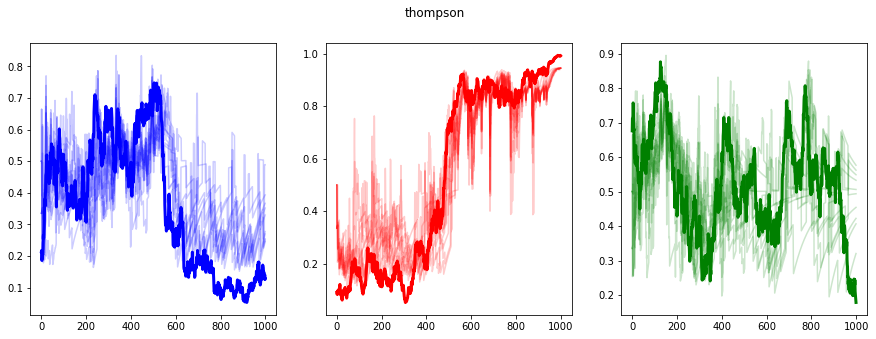

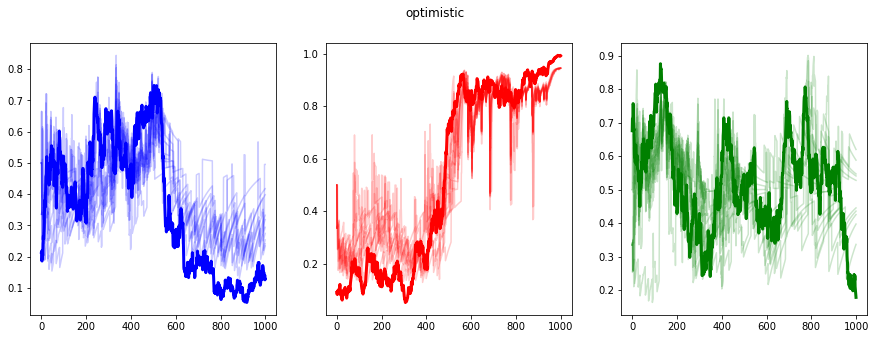

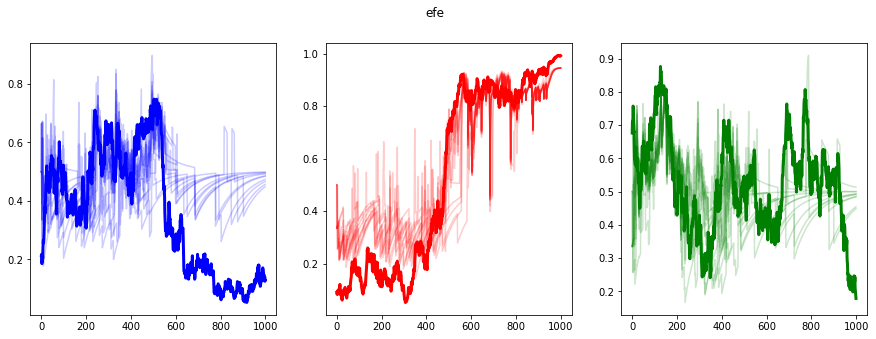

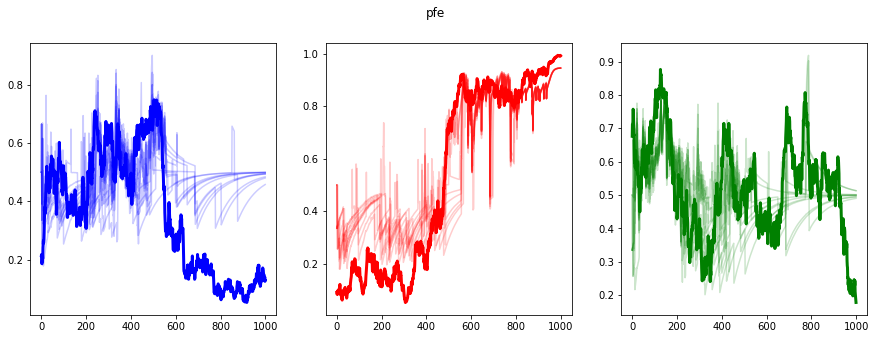

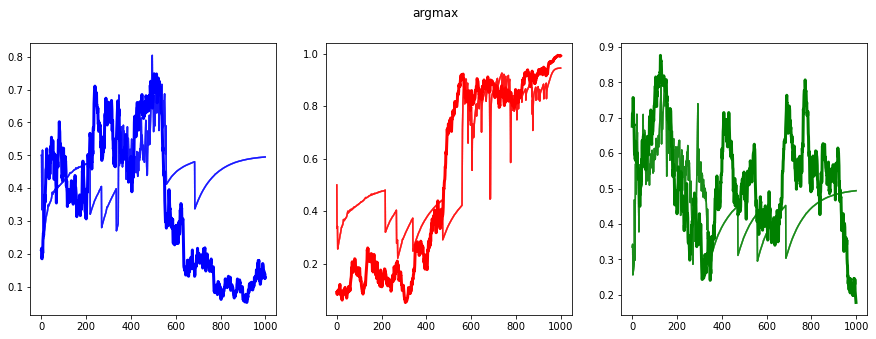

In [6]:
# plot beliefs which were inferred using discretized hidden states
for i, s in enumerate(sequence_states):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    post = s['beliefs']
    post_probs = np.einsum('tnk,lko->tnlo', post.sum(-2), po_ks)
    true_probs = s['probs']

    colours = ['b', 'r', 'g']
    for k in range(K):
        axes[k].plot(post_probs[..., k, k], c=colours[k], alpha=.2)
        axes[k].plot(true_probs[:, k], c=colours[k], lw=3)
    fig.suptitle(labels_states[i])
    plt.show() 


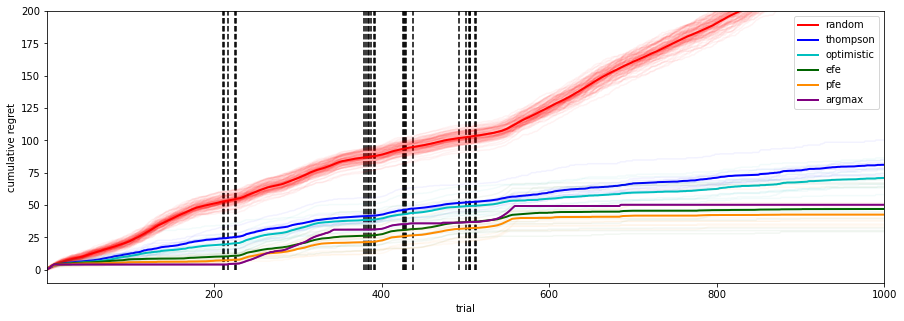

In [7]:
def calc_probs(choices):
    probs = np.stack([lax.index_take(true_probs, [np.arange(T), choices[:, n]], (0, 1)) for n in range(N)], 0)
    return probs

states_probs = [calc_probs(s['choices']) for s in sequence_states]
max_probs = lax.index_take(true_probs, [np.arange(T), true_probs.argmax(-1)], (0, 1))

n_smpl = 100
random_choices = random.categorical(random.PRNGKey(547890), np.zeros(K), shape=(T, n_smpl))
random_probs = np.stack([lax.index_take(true_probs, 
                                        [np.arange(T), 
                                         random_choices[:, n]], (0, 1)) for n in range(n_smpl)], 0)


fig, axes = plt.subplots(1, 1, figsize=(15, 5))

changes = np.concatenate([np.zeros(1), np.abs(np.diff(true_probs.argmax(-1)))], -1)
plt.vlines(np.nonzero(changes), 0, 400, linestyle='--')

line_colors = ['b', 'c', 'darkgreen', 'darkorange', 'purple', 'lime']

regret = np.cumsum(max_probs - random_probs, -1).T
plt.plot(regret, 'r', alpha=.05);
plt.plot(regret.mean(-1), 'r', label='random', lw=2)

for i,probs in enumerate(states_probs):
    regret = np.cumsum(max_probs - probs, -1).T
    plt.plot(regret, line_colors[i], alpha=.05);
    plt.plot(regret.mean(-1), line_colors[i], label=labels_states[i], lw=2)

plt.xlim(1, T)
plt.ylim(-10, 200)
plt.xlabel('trial')
plt.ylabel('cumulative regret')
plt.legend()
plt.show()

To define learning rules based on a parametric model for likelihoods we will start with the following likelihood expressed as a product of Bernoully distribution

$$ p\left(\vec{o}_t|\vec{\theta}_t, s_t=l\right) = \theta_{t,l}^{o_{t,l}}\left( 1-\theta_{t,l} \right)^{1-o_{t,l}} \prod_{m \neq l} \frac{1}{2}^{1-o_{t,m} + o_{t,m}} $$

If we express prior over reward probabilities for each arm as product of beta distributions

$$ p\left(\vec{\theta}_t| \kappa, \vec{o}_{1:t-1}, a_{1:t-1} \right) \propto \prod_k \theta_{t, k}^{\kappa(\alpha_{t-1,k} - 1)} \left( 1 - \theta_{t, k} \right)^{\kappa(\beta_{t-1,k} - 1)}$$

where we assume the following relation between posterior at the previous time step and the predictive prior

$$ p\left(\vec{\theta}_t| \kappa, \vec{o}_{1:t-1}, a_{1:t-1} \right) =  \int d\vec{\theta}_{t-1} p\left(\vec{\theta}_t| \vec{\theta}_{t-1}, \kappa\right) p\left(\vec{\theta}_{t-1}| \vec{o}_{1:t-1}, a_{1:t-1} \right),$$

for some magic transition probability. If we average out the arm selection states $s_t$ we get the following update rule from the Bayes rule

$$p\left(\vec{\theta}_t|\vec{o}_{1:t}, a_{1:t} \right) \propto p\left(\vec{o}_t|\vec{\theta}_t, a_t \right) p\left(\vec{\theta}_t| \kappa, \vec{o}_{1:t-1}, a_{1:t-1} \right) $$

\begin{equation}
    \begin{split}
        \alpha_{t, k} &= o_{t, k} \delta_{a_t, k} + \kappa \alpha_{t-1, k} + 1 - \kappa \\
        \beta_{t, k} &= (1 - o_{t, k}) \delta_{a_t, k} + \kappa \beta_{t-1, k} + 1 - \kappa \\
    \end{split}
\end{equation}

## Thompson sampling

In the case of the Thompsong sampling the action selection rule is obtained as 

$$ a_t = \textrm{argmax}_k \theta^*_{k}, \qquad \vec{\theta}^* \sim p\left(\vec{\theta}_{t}| \kappa, \vec{o}_{1:t-1}, a_{1:t-1} \right)$$

Similarly, the optimistic Thompson sampling corresponds to 

$$ a_t = \textrm{argmax}_k \textrm{max}(\bar{\mu}_{t, k}, \theta^*_{k}), \qquad \vec{\theta}^* \sim p\left(\vec{\theta}_{t}|\kappa, \vec{o}_{1:t-1}, a_{1:t-1} \right)$$

where $\bar{\mu}_{t, k} = \frac{\kappa \alpha_{t-1, k} + 1 - \kappa }{\kappa \nu_{t-1, k} + 2(1 - \kappa)} $, and $\nu_{t-1, k} = \alpha_{t-1, k} + \beta_{t-1, k}$. 

## Active inference

In the case of active inference the action are sampled with the following probability 

$$ p(a_t) \propto e^{-\gamma G(a_t)}$$

where $G(a_t)$ denotes expected free energy defined[<sup>1</sup>](#fn1) as 

$$G(a_t) = D_{KL}\left(Q(\vec{\theta}_t, s_t|a_t)||P(\vec{\theta}_t, s_t) \right) + E_{Q(\vec{\theta}_t, s_t|a_t)}\left[ H[p(\vec{o}_t|\theta_t, s_t)]\right]$$

and corresponds to the upper bound on expected (retrospective) surprisal

\begin{equation}
    \begin{split}
        G(a_t) & \geq E_{Q(\vec{o}_t|a_t)}\left[- \ln P(\vec{o}_t) - D_{KL}\left(Q(s_t, \vec{\theta}_{t}|\vec{o}_t, a_t)| Q(s_t, \vec{\theta}_t| a_t) \right) \right] \\
        &= D_{KL}\left(Q(\vec{o}_t|a_t)| P(\vec{o}_t) \right) + E_{Q(s_t, \vec{\theta}_t|a_t)} \left[H[p(\vec{o}_t|\vec{\theta}_t, s_t)]\right] \\
        &= S(a_t)
    \end{split}
\end{equation}

As $\textrm{argmin}_a G(a) \neq \textrm{argmin}_a S(a)$, it would be interesting if we can minimise either $G(a_t)$ or $S(a_t)$ as different action selection rules. One can link the two quantities via the prior preferences. For example, setting prior preference over reward probabilities as $P(\theta)\propto \theta^{\alpha-1}$, and prior preferences over arms $P(s_t)=\frac{1}{K}$, leads to the following preference over outcomes, $P(o_{t,k}=1|s_t=k) = \frac{\alpha}{\alpha+1}\propto e^{\frac{1}{2}\ln \alpha}$, and $P(o_{t,k}=0|s_t=k) = \frac{1}{\alpha+1}\propto e^{-\frac{1}{2}\ln \alpha}$. However, as under the current deffinition of the generative model $Q(\vec{\theta}|a_t) = Q(\vec{\theta}) = p\left(\vec{\theta}_t| \kappa, \vec{o}_{1:t-1}, a_{1:t-1} \right)$ we get that minimising expected free energy corresponds to minimising expected ambiguity as

$$ G(a_t) = const + E_{Q(\vec{\theta}_t, s_t|a_t)}\left[ H[p(\vec{o}_t|\theta_t, s_t)]\right]$$

Would this lead to useful behaviour in the sense of regret minimisation? 

Alternative would be to figure out how to define the generative model so that $Q(\vec{\theta}|a_t=a) = p(\theta_{t, a}|\kappa, \vec{o}_{1:t-1}, a_{1:t-1})$. Until we figure this out we will focus on minimising the expected surprisal $S(a_t)$. If we define the preferences over outcomes as

$$ P(\vec{o}_t) = \prod_k P(o_{t,k}) \propto \prod_k e^{\lambda (2 o_{t,k} - 1)}$$

and note that  $ Q(s_t, \vec{\theta}_t|a_t) = p(s_t|a_t)p\left(\vec{\theta}_t|\kappa, \vec{o}_{1:t-1}, a_{1:t-1}\right)$, we get the following expression for $S(a_t)$

\begin{equation}
    \begin{split}
        S(a_t) = &- \lambda (2\cdot\bar{\mu}_{t, a_t} - 1) + \bar{\mu}_{t, a_t}\ln\bar{\mu}_{t, a_t} + (1 - \bar{\mu}_{t, a_t}) \ln (1 - \bar{\mu}_{t, a_t}) \\
        &- \frac{B(\bar{\alpha}_{t, a_t} + 1, \bar{\beta}_{t,a_t})}{B(\bar{\alpha}_{t,a_t}, \bar{\beta}_{t,a_t})}\cdot\left(\psi(\bar{\alpha}_{t, a_t}) - \psi(\bar{\nu}_{t, a_t}) \right)- \frac{B(\bar{\alpha}_{t, a_t}, \bar{\beta}_{t,a_t} + 1)}{B(\bar{\alpha}_{t,a_t}, \bar{\beta}_{t,a_t})}\cdot\left(\psi(\bar{\beta}_{t, a_t}) - \psi(\bar{\nu}_{t, a_t}) \right) \\
        & = - \lambda (2\cdot\bar{\mu}_{t, a_t} - 1) + \bar{\mu}_{t, a_t}\left(\ln\bar{\mu}_{t, a_t} -\psi(\bar{\alpha}_{t, a_t})\right) + (1 - \bar{\mu}_{t, a_t}) \left( \ln (1 - \bar{\mu}_{t, a_t}) - \psi(\bar{\beta}_{t, a_t})\right) + \psi(\bar{\nu}_{t, a_t})
    \end{split} 
\end{equation}

where $B(\alpha, \beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}$, and $\frac{B(\alpha+1, \beta)}{B(\alpha, \beta)} = \frac{\alpha}{\alpha + \beta}$ and $\frac{B(\alpha, \beta+1)}{B(\alpha, \beta)} = \frac{\beta}{\alpha + \beta}$.

In [8]:
kappa = 0.92

def parametric_learning(outcomes, choices, priors):
    post_p, post_alpha = priors
    N = choices.shape[0]
    #obs = np.zeros((N,K)) + 0.5
    #for n,k in enumerate(choices):
    #    obs = ops.index_update(obs, ops.index[n,k], outcomes.astype(np.int32)[n,k])
    #alpha_0 = 1 - obs + kappa * post_alpha[:,0] + 1 - kappa
    #alpha_1 = obs + kappa * post_alpha[:,1] + 1 - kappa
    alpha_0 = kappa * post_alpha[:,0] + 1 - kappa
    alpha_1 = kappa * post_alpha[:,1] + 1 - kappa
    obs = outcomes.astype(np.float32)
    for n,k in enumerate(choices):
            alpha_0 = ops.index_update(alpha_0, ops.index[n,k], \
                                       1 - obs[n,k] + alpha_0[n,k])
            alpha_1 = ops.index_update(alpha_1, ops.index[n,k], \
                                   obs[n,k] + alpha_1[n,k])
    q_alpha = np.array([alpha_0, alpha_1]).transpose((1,0,2))
        
    q_p = kappa * q_alpha + 1 - kappa
    q_p /= q_p.sum(axis=-2)[:,np.newaxis,:]
    
    return (q_p, q_alpha)

def parametric_argmax(beliefs, rng_key):
    #Argmax selection
    post_p, post_alpha = beliefs
    outcome_probs = post_p[:,1] # map states to underlying outcome probabilities of different arms
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

def parametric_thompson(beliefs, rng_key):
    #Thompson sampling
    # use kappa*alpha + 1 - kappa instead of post alpha?
    post_p, post_alpha = beliefs
    alpha = kappa * post_alpha + 1 - kappa
    sample = random.dirichlet(rng_key, alpha.transpose((0,2,1)))
    outcome_probs = sample[:,:,1] # map states to underlying outcome probabilities of different arms
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

def parametric_optimistic(beliefs, rng_key):
    #Optimistic thompson sampling
    post_p, post_alpha = beliefs
    # use kappa*alpha + 1 - kappa instead of post alpha?
    alpha = kappa * post_alpha + 1 - kappa
    sample = random.dirichlet(rng_key, alpha.transpose((0,2,1)))
    outcome_probs = sample[:,:,1] # map states to underlying outcome probabilities of different arms
    mean_probs = post_p[:,1,:]
    outcome_probs = np.where(outcome_probs > mean_probs, outcome_probs, mean_probs)
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

H_ks = - np.sum(np.nan_to_num(log_po_ks) * po_ks, -1) \
       - np.sum(np.nan_to_num(log_1_po_ks) * (1 - po_ks), -1)

def parametric_efe(beliefs, rng_key, prop=10, lamb=1.):
    # active inference
    post_p, post_alpha = beliefs
    
    gamma = prop / lamb
    
    #H_s = gammaln(post_alpha[:,0]) + gammaln(post_alpha[:,1]) - gammaln(post_alpha.sum(axis=1)) \
    #        - (post_alpha[:,0]-1)*digamma(post_alpha[:,0]) - (post_alpha[:,1]-1)*digamma(post_alpha[:,1]) \
    #        + (post_alpha.sum(axis=1)-2)*digamma(post_alpha.sum(axis=1))
    mu = post_p[:,1]
    H_s = - mu * (np.log(mu) - digamma(post_alpha[:,1])) \
          - (1 - mu) * (np.log(1 - mu) - digamma(post_alpha[:,0])) \
          - digamma(post_alpha.sum(axis=1))
    
    G_s = lamb * (2 * mu - 1) + H_s
    
    choices = random.categorical(rng_key, gamma * G_s) # sample choices
    return choices

def parametric_pfe(beliefs, rng_key, prop=10, lamb=1.):
    # active inference
    post_p, post_alpha = beliefs
    
    gamma = prop / lamb
    G_s = lamb*(2 * post_p[:,1] - 1)
    
    choices = random.categorical(rng_key, gamma * G_s) # sample choices
    return choices

def parametric_vfe(beliefs, rng_key, gamma=10):
    # active inference
    post_p, post_alpha = beliefs
    G_s = ( digamma(post_alpha[:,1]) - digamma(post_alpha.sum(axis=1)))
    
    choices = random.categorical(rng_key, gamma * G_s) # sample choices
    return choices

def simulator(process, learning, action_selection, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, probs, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = action_selection(prior, _rng_key)
        
        rng_key, _rng_key = random.split(rng_key)
        outcomes, probs = process(t, choices, probs, _rng_key)
        posterior = parametric_learning(outcomes, choices, prior)
                
        return (rng_key, probs, posterior), {'outcomes': outcomes, 
                                              'probs': probs, 
                                              'choices': choices,
                                              'beliefs': posterior}
    
    rng_key = random.PRNGKey(seed)
    probs = random.uniform(rng_key, shape=(K,))
    q_p_init = np.array([0.5,0.5], dtype=np.float32).tile((N,K,1)).transpose((0,2,1))
    q_alpha_init = np.array([1, 1], dtype=np.float32).tile((N,K,1)).transpose((0,2,1))
    prior = (q_p_init, q_alpha_init)
    _, sequence = lax.scan(sim_fn, (rng_key, probs, prior), np.arange(T))
    
    sequence['probs'] = np.concatenate([probs[None], sequence['probs']], 0)[:-1]
    return sequence

In [9]:
N = 10
T = 1000

sequence_parametric = []
labels_parametric = ['parametric thompson', 'parametric optimistic', 'parametric efe', 'parametric pfe', \
                 'parametric argmax', 'parametric vfe']

for selection in [parametric_thompson,
                  parametric_optimistic,
                  parametric_efe,
                  parametric_pfe,
                  parametric_argmax,
                  parametric_vfe]:

    sequence_parametric.append(simulator(process, learning, selection, N=N, T=T))
    gc.collect();

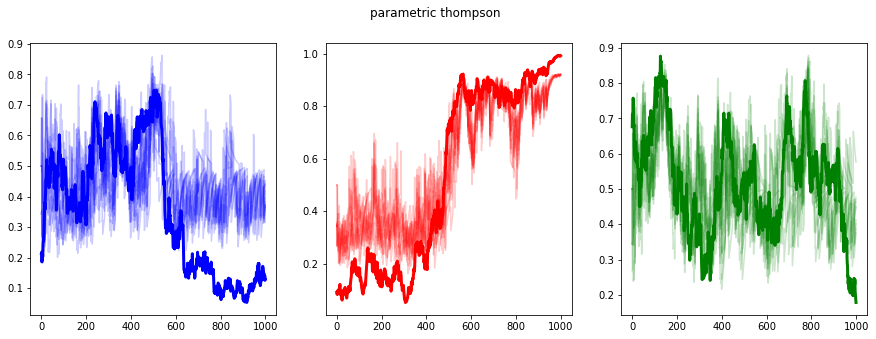

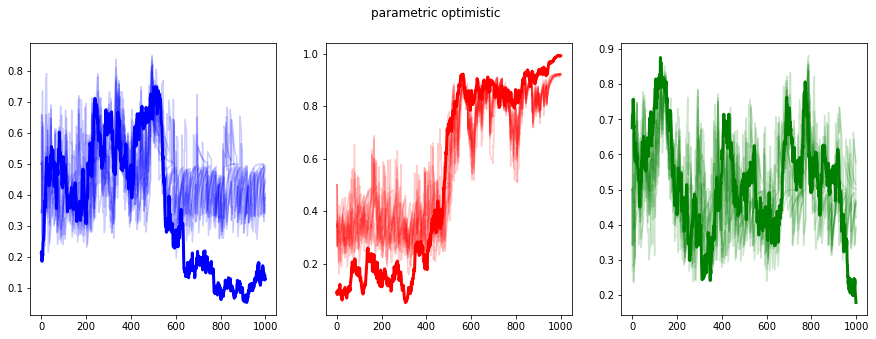

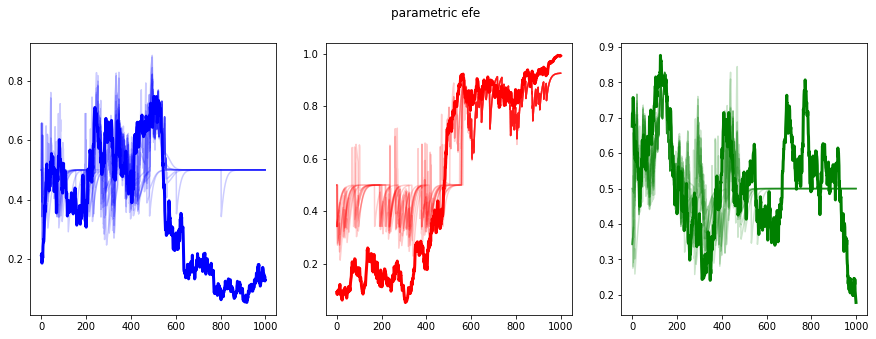

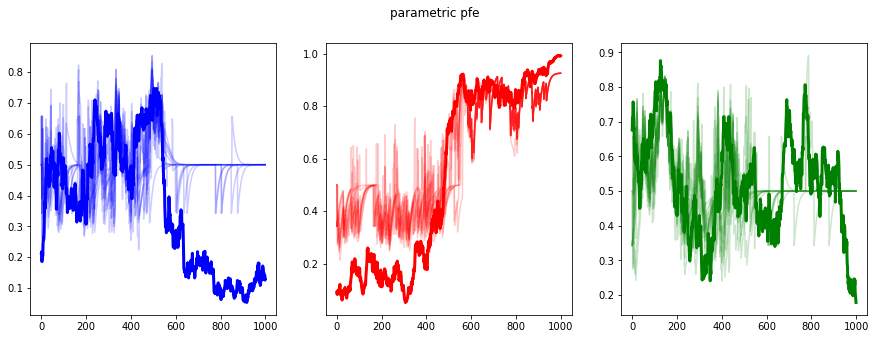

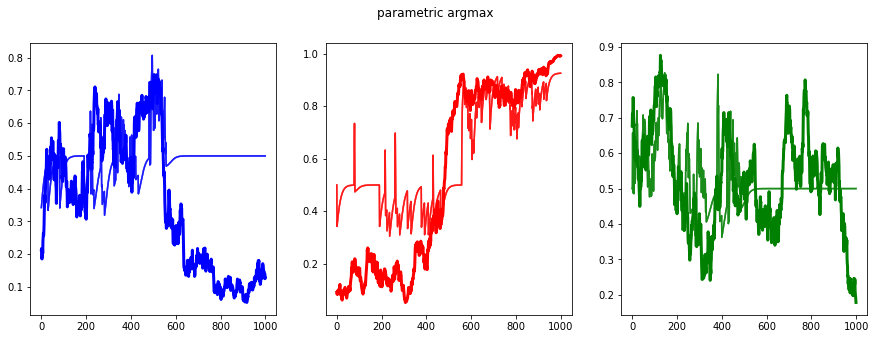

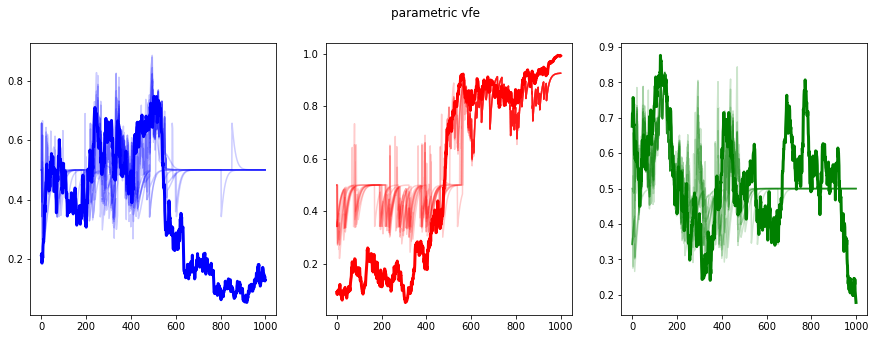

In [10]:
# plot beliefs which were inferred using parametric learning
for i,s in enumerate(sequence_parametric):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    post = s['beliefs']
    post_probs = post[0]
    true_probs = s['probs']

    colours = ['b', 'r', 'g']
    for k in range(K):
        axes[k].plot(post_probs[..., 1, k], c=colours[k], alpha=.2)
        axes[k].plot(true_probs[:, k], c=colours[k], lw=3)
    fig.suptitle(labels_parametric[i])
    plt.show()

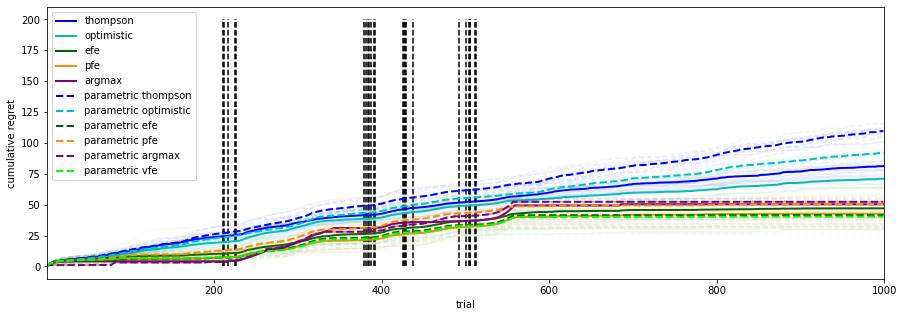

In [12]:
def calc_probs(choices):
    probs = np.stack([lax.index_take(true_probs, [np.arange(T), choices[:, n]], (0, 1)) for n in range(N)], 0)
    return probs

states_probs = [calc_probs(s['choices']) for s in sequence_states]
parametric_probs = [calc_probs(s['choices']) for s in sequence_parametric]

max_probs = lax.index_take(true_probs, [np.arange(T), true_probs.argmax(-1)], (0, 1))

n_smpl = 100
random_choices = random.categorical(random.PRNGKey(547890), np.zeros(K), shape=(T, n_smpl))
random_probs = np.stack([lax.index_take(true_probs, [np.arange(T), random_choices[:, n]], (0, 1)) for n in range(n_smpl)], 0)


fig, axes = plt.subplots(1, 1, figsize=(15, 5))

changes = np.concatenate([np.zeros(1), np.abs(np.diff(true_probs.argmax(-1)))], -1)
plt.vlines(np.nonzero(changes), 0, 200, linestyle='--')

line_colors = ['b', 'c', 'darkgreen', 'darkorange', 'purple', 'lime']

for i,probs in enumerate(states_probs):
    regret = np.cumsum(max_probs - probs, -1).T
    plt.plot(regret, line_colors[i], alpha=.05);
    plt.plot(regret.mean(-1), line_colors[i], label=labels_states[i], lw=2)
    
for i,probs in enumerate(parametric_probs):
    regret = np.cumsum(np.abs(max_probs - probs), -1).T
    plt.plot(regret, line_colors[i], linestyle='--', alpha=.05);
    plt.plot(regret.mean(-1), line_colors[i], linestyle='--', label=labels_parametric[i], lw=2)

plt.xlim(1, T)
plt.xlabel('trial')
plt.ylabel('cumulative regret')
plt.legend()
plt.show()

#sequences = [sequence1, sequence2, sequence3, sequence4]
#labels = ['thompson', 'optimistic', 'efe', 'test']

#fig = plot_cumulative_regret(sequences, labels, true_probs)
#fig.savefig('cum_reg_restless.png', dpi=300)

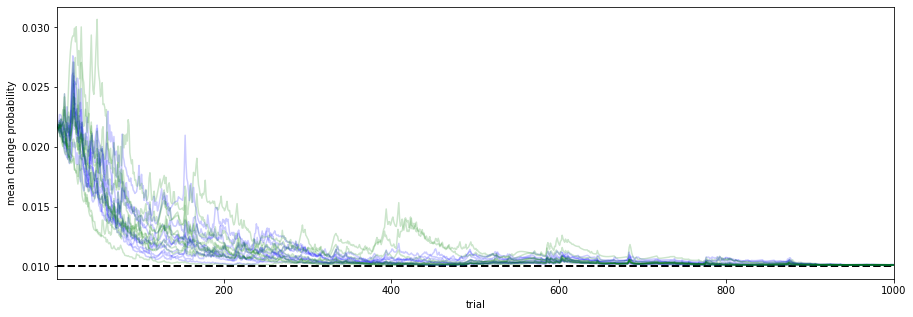

In [12]:
post = [sequence_states[0]['beliefs'], sequence_states[1]['beliefs']]

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for p, c in zip(post, ['b', 'g']):
    marg = p.reshape(T, N, M, -1).sum(-1)
    prob = np.sum(marg * rho.reshape(M), -1)
    
    plt.plot(prob, c, alpha=.2)

plt.hlines(.01, 1, T, 'k', lw=2, linestyle='--')
plt.xlabel('trial')
plt.ylabel('mean change probability')
plt.xlim([1, T])
fig.savefig('change_prob_restless.png', dpi=300)

In [13]:
post = sequence3['beliefs']
post.shape

marg = post.sum(-2)
H_st = np.einsum('tnk,ak->tna', marg, H_ks)
po_st = np.einsum('tnk,ako->tnao', marg, po_ks)

log_po_st = np.nan_to_num(np.log(po_st))
log_1_po_st = np.nan_to_num(np.log(1 - po_st))

IG_st = np.sum(po_st * log_po_st + (1 - po_st) * log_1_po_st, -1) + H_st

NameError: name 'sequence3' is not defined

In [ ]:
plt.subplots(figsize=(15, 5))
plt.plot(- IG_st[:, 0]);

In [ ]:
plt.subplots(figsize=(15, 5))
plt.plot(true_probs)

In [ ]:
N = 5
T = 1000
regrets = []
P = 10
lambdas = np.arange(.1, .25, .03)
ratios = [1., 5., 10.]
ref_regret = []
for ratio in ratios:
    regrets.append([])
    for lam in lambdas:
        efe_sel = lambda x, y: efe_selection(x, y, ratio=ratio, lam=lam)
        sequence = simulator(process, learning, efe_sel, N=N, T=T)
        choices = sequence['choices']
        true_probs = sequence['probs']
        max_probs = lax.index_take(true_probs, [np.arange(T), true_probs.argmax(-1)], (0, 1))
        sel_probs = np.stack([lax.index_take(true_probs, [np.arange(T), choices[:, n]], (0, 1)) for n in range(N)], 0)

        cum_regret = np.cumsum(max_probs - sel_probs, -1).T
        regrets[-1].append(cum_regret[-1])
    
    test = lambda x,y: test_selection(x, y, ratio=ratio)
    sequence = simulator(process, learning, test, N=N, T=T)
    choices = sequence['choices']
    true_probs = sequence['probs']
    max_probs = lax.index_take(true_probs, [np.arange(T), true_probs.argmax(-1)], (0, 1))
    sel_probs = np.stack([lax.index_take(true_probs, [np.arange(T), choices[:, n]], (0, 1)) for n in range(N)], 0)

    cum_regret = np.cumsum(max_probs - sel_probs, -1).T
    ref_regret.append(cum_regret[-1].mean())

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
regrets = np.array(regrets)
for r in range(3):
    plt.plot(lambdas, regrets[r].mean(-1), lw=2, label=ratios[r]) 
    plt.hlines(ref_regret[r], lambdas[0], lambdas[-1], linestyle='--', lw=2)
    
plt.legend(title='ratio')
plt.xlabel(r'$\lambda$')
plt.ylabel('cumulative regret')
fig.savefig('lambda_dependence.png')

To calculate a variational action selection rule, one can now introduce an approximate posterior. 
\begin{equation}
q(a,\theta) \approx p(a,\theta|r=1)
\end{equation}
Here, I propose two different approximate posteriors which I will use for the predicted free energy (pfe) and the expected free energy (efe).

For the pfe decision rule, the approximate posterior reads
\begin{equation}
q(a,\theta) = q(a)q(\theta)
\end{equation}
which yields 
\begin{equation}
F[q] = \sum_a q(a)[\ln \frac{q(a)}{p(a)} + \int d\theta q(\theta) [-\ln p(r=1|a,\theta) + \ln \frac{q(\theta)}{p(\theta)}]]
\end{equation}
For the posterior over actions we get
\begin{align}
\ln q(a) &= \ln p(a) + \int d\theta \ln p(r=1|a,\theta) \\
&= \ln p(a) + \psi(\alpha_{1a}) - \psi(\alpha_{0a}+\alpha_{1a})
\end{align}
where $\psi$ is the digamma function. This selection rule is implemented in the parametric_vfe action selection function below.

For the efe decition rule, the approximate posterior was chosen as
\begin{equation}
q(a,\theta) = q(a)q(\theta|a)
\end{equation}
which yields 
\begin{equation}
F[q] = \sum_a q(a)[\ln \frac{q(a)}{p(a)} + \int d\theta q(\theta|a) [-\ln p(r=1|a,\theta) + \ln \frac{q(\theta|a)}{p(\theta)}]]
\end{equation}
which changes the posterior over actions to
\begin{align}
\ln q(a) &= \ln p(a) + \int d\theta q(\theta|a) \ln p(r=1|a,\theta) - \int d\theta q(\theta|a) \ln q(\theta|a) \\
&= \ln p(a) + \psi(\alpha_{1a}) - \psi(\alpha_{0a}+\alpha_{1a}) + H[q(\theta|a)]
\end{align}
so that it contains the entropy $H[q(\theta|a)]$, which is implemented in the parametric_efe action selection below. This should make exploration more likely, and should in theory improve cumulative regret. In practice, at least for the current version of the learning rule, the agent seems to explore too much which increases its cumulative regret, see below.